# Retrieving Pseudo-MPC Observations for JUICE

## Objectives
In this example show how to retrieve pseudo-MPEC data from a **selected webpage** that does not belong to any of the [official sources](https://astroquery.readthedocs.io/en/latest/index.html#available-services) used by astroquery. Check out the [Workflow section](#Workflow) for an exaplanation of why this might turn out to àbe useuful. We will then use the Tudat Horizons interface to compare observation ouput. 

## Key API References

## Import Statements
First, let's import the relevant modules we will be using throughout this example.
Apart from the usual tudatpy modules, we will also need the HorizonsQuery module, some astroquery modules (MPC, Table, Column) and the BeautifulSoup library.

In [1]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation_setup
from tudatpy.kernel.numerical_simulation import estimation

from tudatpy.astro import frame_conversion
from tudatpy.astro import time_conversion
from tudatpy.kernel import numerical_simulation
from astropy.time import Time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.lines import Line2D
import matplotlib.cm as cm

from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.table import Table, Column
from bs4 import BeautifulSoup

from tudatpy.util import result2array
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

### Importing Kernels
We also load the standard kernels, also making sure to add the latest JUICE orbital one.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Load spice kernels
path = os.getcwd()
kernels = [path+'/juice_orbc_000073_230414_310721_v01.bsp']
spice.load_standard_kernels(kernels)

## Workflow
<a id='Workflow'></a>
In [the previous example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/estimation/retrieving_mpc_observation_data.html), we explained how to retrieve **optical data** from the [Minor Planet Centre](https://www.minorplanetcenter.net/). The MPC receives and stores optical observations  (RA and DEC) of natural objects (asteroids, comets, minor planets) from observatories across the world and stores them into Minor Planet Electronic Circulars (MPECs). However, not all objects falling in the Field of View of an optical telescope are natural bodies: in some cases, artificial objects (such as space missions) can be tracked by optical telescopes as well. This was recently the case for the JUICE mission, for which some optical observations have been collected by observatories around the world. You won't find JUICE astrometry on the MPC, but it can be found at [this webpage](https://www.projectpluto.com/pluto/mpecs/23053a.htm#ast) in the form of a pseudo-MPEC.

Unlike what shown in the MPC example, we cannot directly initialize a BatchMPC object for JUICE, since astroquery is only able to retrieve data from [official sources](https://astroquery.readthedocs.io/en/latest/index.html#available-services). We therefore need to:

1) parse the html page containing the wanted data, retrieving information (observation times, angular observables, station codes, observation bands, etc...).
2) feed this information into a table that has the same format as the one created by tudat using the `.get_observations()`.
3) convert the newly created table into a `Batch.MPC` object using the `.from_astropy()` function.
### 1) Parsing the html page
For this step, we need to parse the html page containing the JUICE astrometry. This step is - in general - highly webpage-dependent. This example is tailored to the JUICE astrometry collected by astronomer Bill Gray and stored in his [website](https://projectpluto.com). In this cell, we parse the html and retrieve observations epoch and number, angular coordinates, observation bands and observatories codes for (most) observations present in the webpage. 

In [3]:
MPC.query_object = requests.get("https://www.projectpluto.com/pluto/mpecs/23053a.htm", "-28")
observations = MPC.query_object.text

# Find the position of the <a name="stations"></a> tag
match = re.search(r'<a name="stations"></a>', observations)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = observations[:match.start()]
    
match = re.search(r'<a href="https://www.projectpluto.com/mpec_xpl.htm#astrometry"> <b>Astrometry:</b> </a>', html_cleaned)

if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = html_cleaned[match.end():].lstrip()
observations = [line.strip() for line in html_cleaned.splitlines() if line.strip()]

# Initialize lists to hold the extracted data
obs_numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i,line in enumerate(observations):
    soup = BeautifulSoup(line, 'html.parser')
    obs_number = i+1
    observation_string = soup.get_text()

    match = re.search(r'2024.*', observation_string)
    match_ = re.search(r'K24.*', observation_string)

    if match:
        # Extract the observation string starting from '2024'
        observation_string = match.group(0).strip()
        
        # Now we want to ensure that observation_string[2] is '2' of '2024'
        year = observation_string[0:4]
        month = observation_string[5:7]
        date_part, frac_day = observation_string[8:17].split('.')
        obs_numbers.append(obs_number)
        
    else:
        if match_:
            observation_string = match_.group(0).strip()
            year = str(f'20{observation_string[1:3]}')
            month = observation_string[3:5]
            date_part, frac_day = observation_string[6:15].split(':')
            obs_numbers.append(obs_number)

    # Calculate the time in hours, minutes, seconds
    hours = float("0." + frac_day) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    seconds_int = int(seconds)
    microseconds = int((seconds - seconds_int) * 1_000_000)
    # Convert to Julian date
    time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{seconds:02}"
    epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{seconds_int:02}.{microseconds:06}'
    dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S.%f")
    dt_jd = Time(dt).jd
    epochs.append(dt_jd)

    ra_dec_str = observation_string[17:43]  # RA and DEC part, RA in hours, DEC in degrees
    ra_part = ra_dec_str[:12].strip()  # Right Ascension
    dec_part = ra_dec_str[12:].strip()  # Declination


    #Right Ascension
    parts_RA = ra_part.split()
    hours_RA = float(parts_RA[0]) 
    minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
    seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
    deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

    #Declination
    parts_DEC = dec_part.split()
    degrees_DEC = float(parts_DEC[0])
    minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
    seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
    if len(parts_DEC[0]) == 3:
        deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
    else:
        deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        
    # Extract Band
    band = observation_string[55:57]
    bands.append(band)

    # Extract the observatory code
    observatory = soup.find_all('a')[2].get_text().strip()
    observatories.append(observatory)
 
    rad_ra = (np.radians(deg_ra) + np.pi) % (2*np.pi) - np.pi #Normalize RA to the interval [-pi,pi]
    RAs.append(np.degrees(rad_ra)) #in degrees
    DECs.append(deg_dec) #in degrees

Note that RA and Dec are given in **degrees** (they could be given in radians, but we leave it this way to be consistent with the previous JUICE example).

### 2) Feeding the table
 Now it's time to create and feed a table with the data we just retrieved. The table has to be given in the same format as the one shown in the MPC example.

In [4]:
# Create the table
table = Table()

# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['-28']*len(obs_numbers))))
table.add_column(Column(name='designation', data= np.transpose(['JUICE']*len(obs_numbers))))
table.add_column(Column(name='discovery', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='note1', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='note2', data= np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='mag', data=np.transpose(['NaN']*len(obs_numbers))))
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

number designation discovery note1 ...         DEC         mag band observatory
                                   ...         deg                             
------ ----------- --------- ----- ... ------------------- --- ---- -----------
   -28       JUICE       NaN   NaN ... -11.055930555555557 NaN   wX         F51
   -28       JUICE       NaN   NaN ... -11.055161111111111 NaN   wX         F51
   -28       JUICE       NaN   NaN ... -11.054400000000001 NaN   wX         F51
   -28       JUICE       NaN   NaN ... -10.986169444444444 NaN   GV         H21
   -28       JUICE       NaN   NaN ... -10.985580555555554 NaN   GV         H21
   -28       JUICE       NaN   NaN ... -10.959388888888888 NaN   GV         T14
   -28       JUICE       NaN   NaN ... -10.959302777777777 NaN   GV         T14
   -28       JUICE       NaN   NaN ... -10.959211111111111 NaN   GV         T14
   -28       JUICE       NaN   NaN ... -10.913844444444445 NaN   GV         Q64
   ...         ...       ...   ... ...  

### Creating the BatchMPC object
We can finally create a batch object and act upon it with *from.astropy*. This will create the final table, and the procedure outlined so far is basically equivalent to the *get_observations* function used in the original example.

We can also filter the 

Note that batch.table.query gives RA and DEC in **radians**. 

In [5]:
batch = BatchMPC()
batch.from_astropy(table, in_degrees = True)
batch.summary()

#print results to make sure everything is fine
print(batch.table)
print(batch.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
print('\n')

#these are outliers, together with J95
obs_by_Y05 = batch.table.query("observatory == 'Y05'").loc[:, ["number", "epochUTC", "RA", "DEC"]]
print(obs_by_Y05)


   Batch Summary:
1. Batch includes 1 minor planets:
   ['-28']
2. Batch includes 99 observations, including 0 observations from space telescopes
3. The observations range from 2024-07-05 14:03:50.486391 to 2024-08-17 07:33:53.280006
   In seconds TDB since J2000: 773460299.6704056 to 777152102.462934
   In Julian Days: 2460497.086001 to 2460539.8152
4. The batch contains observations from 17 observatories, including 0 space telescopes

   number designation discovery note1 note2         epoch        RA       DEC  \
0     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457648 -0.192962   
1     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457632 -0.192949   
2     -28       JUICE       NaN   NaN   NaN  2.460497e+06 -0.457615 -0.192936   
3     -28       JUICE       NaN   NaN   NaN  2.460498e+06 -0.453799 -0.191745   
4     -28       JUICE       NaN   NaN   NaN  2.460498e+06 -0.453783 -0.191735   
..    ...         ...       ...   ...   ...           ...       ...     

## Visualizing Differences with JPL Horizons Coordinates

Just as done in the original MPC example, let's plot the difference between the expected (i.e., JPL Horizon) coordinates and our observations (retrieved from the webpage).

In [6]:
# Retrieve MPC observation times, RA and DEC from batch object
batch_times = batch.table.epochJ2000secondsTDB.to_list()
batch_times_utc = batch.table.epochUTC.to_list()
batch_RA = batch.table.RA #in radians
batch_DEC = batch.table.DEC #in radians

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="-28",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
jpl_RA = jpl_observations[:, 1] % np.pi - np.pi #normalize RA to the interval [-pi,pi]
jpl_DEC = jpl_observations[:,2]

#take the difference
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()

print("Maximum difference between Interpolated Horizons data and MPC observations...")
print(f"...in Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"...in Declination: {np.round(max_diff_DEC, 10)} rad")

print("Minimum difference between Interpolated Horizons data and MPC observations...")
print(f"...in Right Ascension: {np.round(min_diff_RA, 10)} rad")
print(f"...in Declination: {np.round(min_diff_DEC, 10)} rad")

Maximum difference between Interpolated Horizons data and MPC observations...
...in Right Ascension: 0.0072537142 rad
...in Declination: 0.0071848375 rad
Minimum difference between Interpolated Horizons data and MPC observations...
...in Right Ascension: 3.4069e-06 rad
...in Declination: 0.0001650893 rad


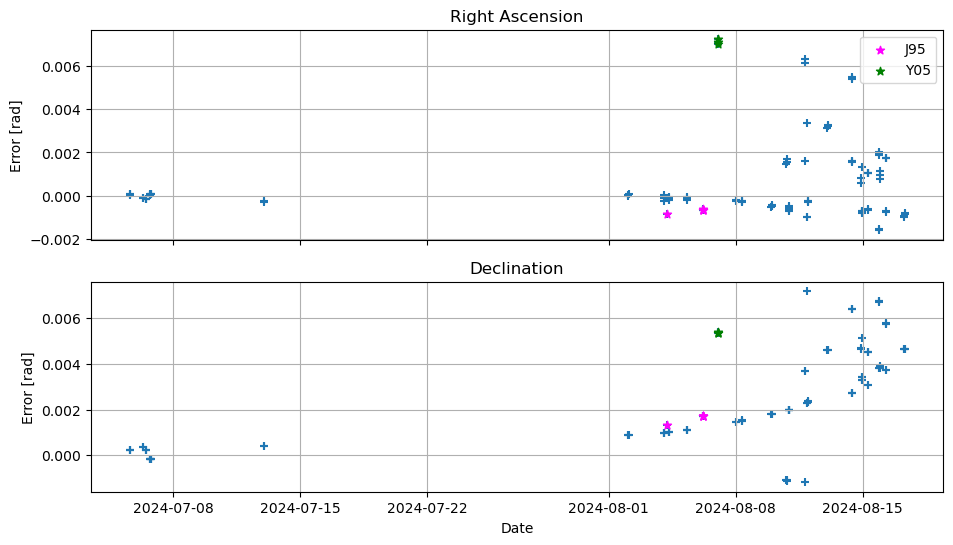

In [7]:
#Create plot to visualize ther observations and select outliers from Y05 and J95
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

time_outliers_J95 = [batch_times_utc[25],batch_times_utc[29],batch_times_utc[30],batch_times_utc[31], batch_times_utc[32]]
RA_outliers_J95 = [jpl_RA[25] - batch_RA[25],jpl_RA[29] - batch_RA[29],jpl_RA[30] - batch_RA[30],jpl_RA[31] - batch_RA[31],jpl_RA[32] - batch_RA[32]]
DEC_outliers_J95 = [jpl_DEC[25] - batch_DEC[25],jpl_DEC[29] - batch_DEC[29],jpl_DEC[30] - batch_DEC[30],jpl_DEC[31] - batch_DEC[31],jpl_DEC[32] - batch_DEC[32]]

time_outliers_Y05 = [batch_times_utc[92],batch_times_utc[93],batch_times_utc[94]]
RA_outliers_Y05 = [jpl_RA[92] - batch_RA[92],jpl_RA[93] - batch_RA[93],jpl_RA[94] - batch_RA[94]]
DEC_outliers_Y05 = [jpl_DEC[92] - batch_DEC[92],jpl_DEC[93] - batch_DEC[93],jpl_DEC[94] - batch_DEC[94]]
ax_ra.scatter(time_outliers_J95, RA_outliers_J95, marker="*", color = 'fuchsia', label = 'J95')
ax_ra.scatter(time_outliers_Y05, RA_outliers_Y05, marker="*", color = 'green', label = 'Y05')
ax_dec.scatter(time_outliers_J95, DEC_outliers_J95, marker="*", color = 'fuchsia', label = 'J95')
ax_dec.scatter(time_outliers_Y05, DEC_outliers_Y05, marker="*", color = 'green', label = 'Y05')


ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")
ax_ra.legend()
plt.show()

### Plotting observations
The `.plot_observations_sky()` method can be used to view a projection of the observations. 


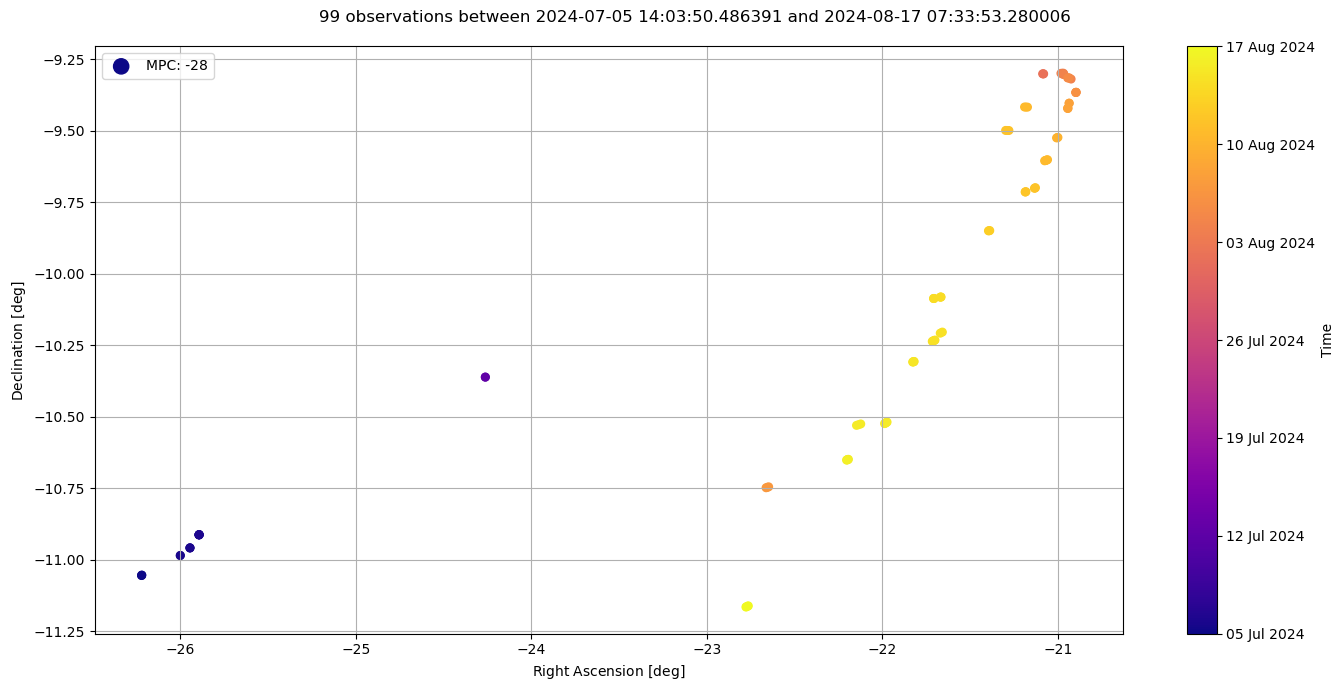

In [8]:
# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch.plot_observations_sky()
plt.show()

### Retrieve Observation Collection
We can now retrieve the observation collection object, using the *to_tudat* method.

In [9]:
# List the bodies for our environment

bodies_to_create = [
    "Sun", 
    "Earth", 
    "Moon", 
    "Jupiter", 
    "Saturn", 
    "Mars", 
    "Mercury", 
    "Neptune", 
    "Uranus", 
    "Venus"
]

# Create default body settings
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve JUICE' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin]

#filter out the outliers
batch.filter(observatories_exclude = ['Y05', 'J95'])
observation_collection = batch.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

## Buffer Times

In [10]:
# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer_start = 86400
time_buffer_end = 86400*10

# timestep of 300s for our estimation
timestep_global = 60*4

epoch_start_buffer = epoch_start_nobuffer - time_buffer_start
epoch_end_buffer = epoch_end_nobuffer + time_buffer_end

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

Epoch Start (no buffer): 773460299.6704056
Epoch End (no buffer): 777152102.462934
Epoch Start (with buffer): 773373899.6704056
Epoch End (with buffer): 778016102.462934


## Defining Acceleration Models

In [11]:
# Create radiation pressure settings
reference_area_radiation = 100 #m^2
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth", "Moon"]
vehicle_target_settings = (
    environment_setup.radiation_pressure.cannonball_radiation_target(
        reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict
    )
)

environment_setup.add_radiation_pressure_target_model(
    bodies, "-28", vehicle_target_settings
)


#Create quasi impulsive shot manuever
epoch_impulse_0 = f'2024-08-04 12:00:00'
impulse_time_0= datetime.strptime(epoch_impulse_0, "%Y-%m-%d %H:%M:%S")
impulse_jd_0 = Time(impulse_time_0).jd
impulse_j2000 = time_conversion.julian_day_to_seconds_since_epoch(impulse_jd_0)

# Define the quasi-impulsive shot settings
mid_times = [impulse_j2000]
delta_v_values = [ np.array([0.0, 0.0, 0.0])]
maneuver_duration = 60*40
rise_time = 60*10

# Define acceleration model
acceleration_settings_on_spacecraft = dict()
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
        propagation_setup.acceleration.radiation_pressure(),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.spherical_harmonic_gravity(2,0)],
    "Moon": [propagation_setup.acceleration.spherical_harmonic_gravity(4,0)],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
    "-28" :[propagation_setup.acceleration.quasi_impulsive_shots_acceleration(mid_times,delta_v_values,maneuver_duration,rise_time)]
}

# Set up the accelerations settings for each body, in this case it is only -28 (JUICE)
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

# create the acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

## Initial States and Offset

In [12]:
np.random.seed = 1

initial_position_offset = 1e5
initial_velocity_offset = 10

ephemeris_states = JUICE_horizons_query.cartesian('J2000')

spice_states = []
for epoch in batch_times:
    state = spice.get_body_cartesian_state_at_epoch(
        '-28',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )

    spice_states.append(state)


initial_state = ephemeris_states[0,1:]

initial_state_spice = spice_states[0]
print(batch_times[0])
print(ephemeris_states[0,0])

print(initial_state)
print(initial_state_spice)
initial_guess = initial_state.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

initial_guess_spice = initial_state_spice.copy()
initial_guess_spice[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess_spice[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_state)
print(initial_guess_spice - initial_state_spice)


x_horizons = [state[1] for state in ephemeris_states]
y_horizons = [state[2] for state in ephemeris_states]
z_horizons = [state[3] for state in ephemeris_states]


x_spice = [state[0] for state in spice_states]
y_spice= [state[1] for state in spice_states]
z_spice= [state[2] for state in spice_states]


773460299.6704056
773460299.6704
[ 1.21473126e+10 -5.98130186e+09 -2.64190263e+09 -3.09142488e+03
  2.40294951e+03  1.04557452e+03]
[ 1.21473128e+10 -5.98130198e+09 -2.64190278e+09 -3.09142469e+03
  2.40294972e+03  1.04557511e+03]
Error between the real initial state and our initial guess:
[ 9.79472423e+04 -6.73955299e+04 -2.95555572e+04 -1.05437904e+00
  3.12892221e+00 -6.38218238e-01]
[4.05386298e+04 9.51030738e+04 3.23736300e+04 5.68401153e+00
 8.85084505e+00 4.06627567e+00]


## Propagation Settings

In [13]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=timestep_global,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=['Earth'],
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition
)

# Create propagation settings
propagator_settings_spice = propagation_setup.propagator.translational(
    central_bodies=['Earth'],
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess_spice,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition
)

print(central_bodies)
print(acceleration_models)
print(bodies_to_propagate)
print(initial_guess)
print(epoch_start_buffer)
print(integrator_settings)
print(termination_condition)

['Earth']
{'-28': {'-28': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x148f1dc70>], 'Earth': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x14984f2f0>], 'Venus': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x14984ccb0>], 'Mars': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x148e32870>], 'Jupiter': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x148e32030>], 'Saturn': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x1498524b0>], 'Neptune': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x149853a70>], 'Mercury': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x149853870>], 'Sun': [<tudatpy.kernel.numerical_simulation.propagation.AccelerationModel object at 0x1498507b0>, <tudatpy.kernel.numerical_simulation.propagation.AccelerationM

## Creating Simulator Objects

In [14]:
### VEHICLE BODY ###
# Create vehicle object
bodies.get("-28").mass = 1800*2 #kg

# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

dynamics_simulator_spice = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings_spice
)
# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

states_spice = dynamics_simulator_spice.propagation_results.state_history
states_array_spice = result2array(states_spice)
print(states_array)

[[ 7.73373900e+08  1.21474105e+10 -5.98136926e+09 ... -3.09247926e+03
   2.40607843e+03  1.04493631e+03]
 [ 7.73374140e+08  1.21466683e+10 -5.98079182e+09 ... -3.09252215e+03
   2.40591405e+03  1.04486468e+03]
 [ 7.73374380e+08  1.21459261e+10 -5.98021442e+09 ... -3.09256503e+03
   2.40574968e+03  1.04479306e+03]
 ...
 [ 7.78015740e+08 -7.71517453e+08  1.56984921e+09 ... -1.03352314e+03
   2.28638277e+03  1.84194272e+03]
 [ 7.78015980e+08 -7.71765501e+08  1.57039794e+09 ... -1.03354915e+03
   2.28636292e+03  1.84192231e+03]
 [ 7.78016220e+08 -7.72013556e+08  1.57094667e+09 ... -1.03357518e+03
   2.28634309e+03  1.84190190e+03]]


## Propagation Comparison (SPICE and Horizons)

12147312799.409084
12147353338.038889


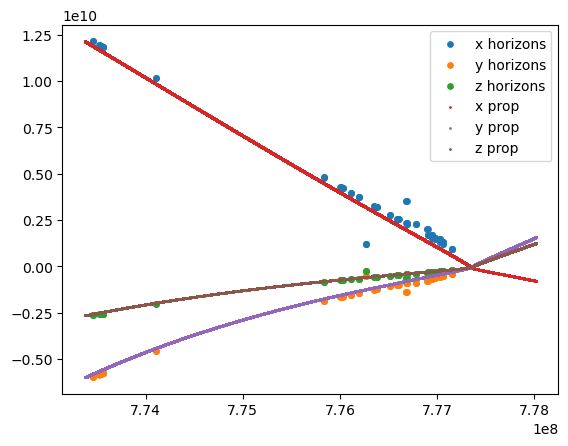

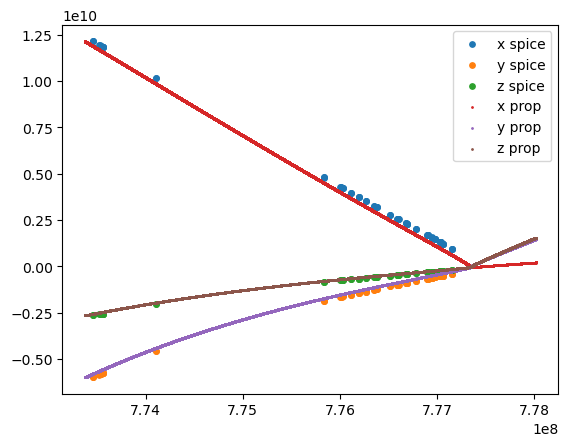

Error between the real spice final state and our final state:
[-1.73906973e+09  1.97783679e+09  1.45742272e+09  1.86385452e+03
  1.23358650e+03  1.37491195e+03]
[-7.52835671e+08  1.88759145e+09  1.76061168e+09  3.24990953e+03
  1.03753318e+03  1.74693987e+03]


In [15]:
time_prop = [state[0] for state in states_array]

x_prop = [state[1] for state in states_array]
y_prop = [state[2] for state in states_array]
z_prop = [state[3] for state in states_array]

time_prop_spice = [state[0] for state in states_array_spice]

x_prop_spice = [state[1] for state in states_array_spice]
y_prop_spice = [state[2] for state in states_array_spice]
z_prop_spice = [state[3] for state in states_array_spice]

print(initial_state_spice[0])
print(x_prop_spice[0])

plt.scatter(batch_times, x_horizons, s = 15, label = 'x horizons')
plt.scatter(batch_times, y_horizons, s = 15, label = 'y horizons')
plt.scatter(batch_times, z_horizons, s = 15, label = 'z horizons')

plt.scatter(time_prop, x_prop, s = 1, label = 'x prop')
plt.scatter(time_prop, y_prop, s = 1, label = 'y prop')
plt.scatter(time_prop, z_prop, s = 1, label = 'z prop')

plt.legend()
plt.show()

plt.scatter(batch_times, x_spice, s = 15, label = 'x spice')
plt.scatter(batch_times, y_spice, s = 15, label = 'y spice')
plt.scatter(batch_times, z_spice, s = 15, label = 'z spice')

plt.scatter(time_prop_spice, x_prop_spice, s = 1, label = 'x prop')
plt.scatter(time_prop_spice, y_prop_spice, s = 1, label = 'y prop')
plt.scatter(time_prop_spice, z_prop_spice, s = 1, label = 'z prop')

plt.legend()
plt.show()

states_array[:]
print("Error between the real spice final state and our final state:")
print(states_array[-1][1:] - ephemeris_states[-1][1:])
print(states_array_spice[-1][1:] - spice_states[-1][:])

## Estimation Settings

In [16]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

parameter_settings.append(estimation_setup.parameter.radiation_pressure_coefficient('-28'))
parameter_settings.append(estimation_setup.parameter.quasi_impulsive_shots('-28'))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
print(f'Truth Parameters: \n {truth_parameters}')

Truth Parameters: 
 [ 1.21474105e+10 -5.98136926e+09 -2.64193218e+09 -3.09247926e+03
  2.40607843e+03  1.04493631e+03  1.20000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


## Observation Settings

In [17]:
# Setup observation settings
observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )

## Estimation

In [18]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

maximum_iterations = 7

# provide the observation collection as input, and limit number of iterations for estimation.
estimation_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=maximum_iterations,
    ),
)

estimation_input.define_estimation_settings(
    reintegrate_variational_equations=True,
    save_state_history_per_iteration=True)

weights_per_observable = {estimation_setup.observation.angular_position_type: (5.52488e-06)**-2}
estimation_input.set_constant_weight_per_observable(weights_per_observable)

estimation_output = estimator.perform_estimation(estimation_input)
residual_history = estimation_output.residual_history
formal_errors = estimation_output.formal_errors
print(f'formal errors: {formal_errors}')
print(estimation_output.simulation_results_per_iteration[-1])

estimated_parameters = parameters_to_estimate.parameter_vector
print(f'Estimated Parameters: \n {estimated_parameters}')

Calculating residuals and partials 182
formal errors: [6.47101986e+06 3.21880129e+06 1.42295319e+06 2.10945764e+00
 1.46816564e+00 6.43642117e-01 1.46985317e+00 2.20642384e+00
 8.39160478e-01 3.79109367e-01]
Estimated Parameters: 
 [ 1.24007260e+10 -6.18595042e+09 -2.73091037e+09 -3.07494465e+03
  2.46139896e+03  1.07105511e+03  1.06749815e+00  2.98737180e+00
 -1.10918538e+00 -4.98965728e-01]
Current residual: 0.0148684
Parameter update 1.42419e+08 -1.48544e+08 -6.37883e+07      124.559     -3.96027     -1.14929      -120.41      -392.61      146.629      68.6371
Calculating residuals and partials 182
Current residual: 0.00276127
Parameter update 5.40433e+07 -2.77837e+07 -1.25817e+07     -49.1942      26.7629      12.6213      44.3788      228.075     -85.4268     -40.0263
Calculating residuals and partials 182
Current residual: 0.000324625
Parameter update 4.75782e+07 -2.36382e+07 -1.05589e+07     -51.8882      28.9199      13.0423      69.4758        155.1     -57.7008     -26.9622
C

Warning when performing least squares, condition number is 3.32103e+08
Warning when performing least squares, condition number is 2.72559e+08
Warning when performing least squares, condition number is 2.51643e+08
Warning when performing least squares, condition number is 2.45597e+08
Warning when performing least squares, condition number is 2.45323e+08
Warning when performing least squares, condition number is 2.45323e+08
Warning when performing least squares, condition number is 2.45323e+08


## Post-Fit Residuals

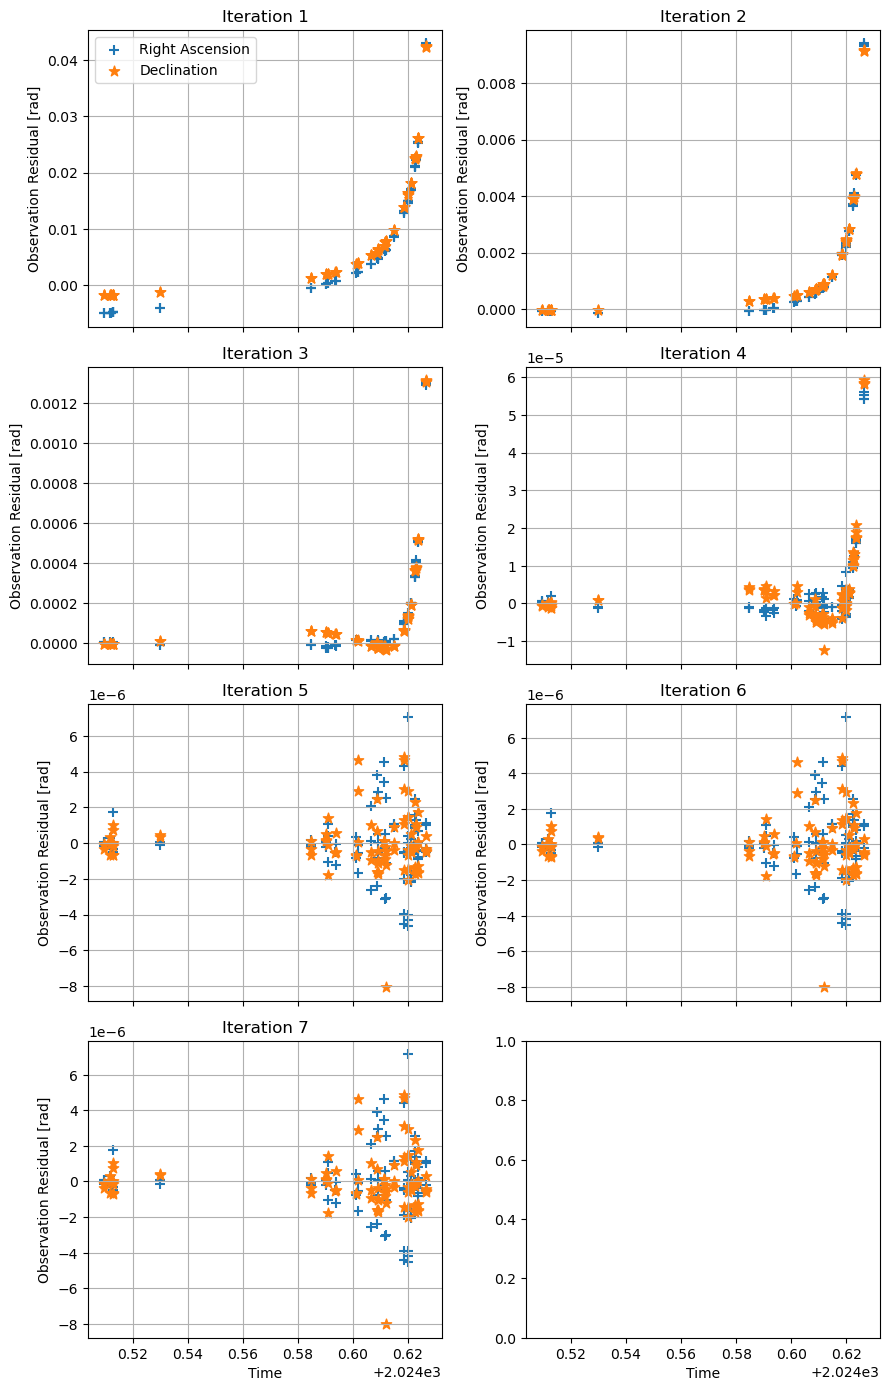

In [19]:
# Number of columns and rows for our plot
number_of_columns = 2

number_of_rows = (
    int(maximum_iterations / number_of_columns)
    if maximum_iterations % number_of_columns == 0
    else int((maximum_iterations + 1) / number_of_columns)
)


fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)

# We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
residual_times = (
    np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
)


# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    if idx != maximum_iterations:
        ax.grid()
        ax.scatter(
            residual_times[::2],
            residual_history[
                ::2,
                idx,
            ],
            marker="+",
            s=60,
            label="Right Ascension",
        )
        ax.scatter(
            residual_times[1::2],
            residual_history[
                1::2,
                idx,
            ],
            marker="*",
            s=60,
            label="Declination",
        )
        ax.set_ylabel("Observation Residual [rad]")
        ax.set_title("Iteration " + str(idx + 1))
    else:
        continue
plt.tight_layout()

# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Time")

axs[0, 0].legend()

plt.show()

## Simulated vs Retrieved Observations

91


/var/folders/vw/h3bwl54d4h9fxt45xnkxm86jgk0dgk/T/ipykernel_17613/312542732.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


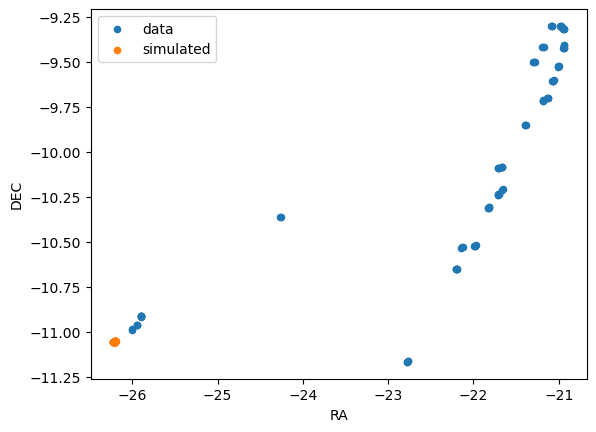

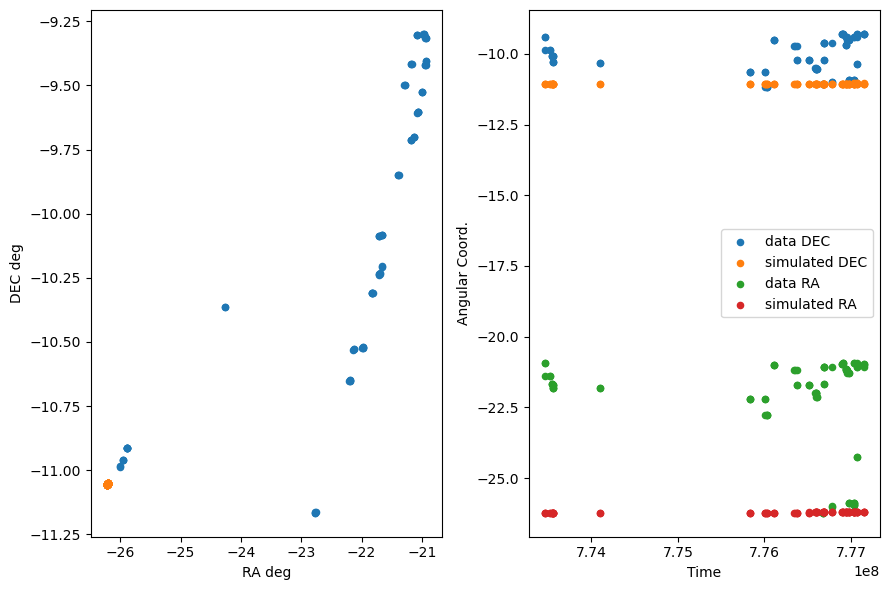

In [20]:
# Define observation simulation times for each link (separated by steps of one minute)
batch_times = batch.table.epochJ2000secondsTDB.to_list()

observation_times = np.arange(epoch_start_nobuffer, epoch_end_nobuffer, 60)
observation_simulation_settings = list()

#create link definitions
for link in link_list:
    observation_simulation_settings.append(observation.tabulated_simulation_settings(
        observation.angular_position_type,
        link,
        observation_times))

#add noise level to observables
noise_level = 1e-5
observation.add_gaussian_noise_to_observable(
    observation_simulation_settings,
    noise_level,
    observation.angular_position_type
)

# Create integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)
# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(epoch_end_nobuffer)

# Create Propagator Settings 
propagator_settings_simulation = propagation_setup.propagator. \
    translational(central_bodies=central_bodies,
                  acceleration_models=acceleration_models,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_guess_spice,
                  initial_time=epoch_start_buffer,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_settings)

propagator_settings_simulation.processing_settings.set_integrated_result = True


# Create observation simulators
observation_simulators = estimation_setup.create_observation_simulators(
    observation_settings_list, bodies)
# Get JUICE simulated observations as ObservationCollection
juice_simulated_observations = estimation.simulate_observations(
    observation_simulation_settings,
    observation_simulators,
    bodies)

observation_times = np.unique(observation_collection.concatenated_times)

RA_obs_list = []
RA_sim_list = []
DEC_obs_list = []
DEC_sim_list = []

for j,i in enumerate(observation_collection.concatenated_observations):
    if (j % 2) == 0:
        RA_obs_list.append(observation_collection.concatenated_observations[j])
        RA_sim_list.append(juice_simulated_observations.concatenated_observations[j])
    elif j == 181:
        DEC_obs_list.append(observation_collection.concatenated_observations[j])
        DEC_sim_list.append(juice_simulated_observations.concatenated_observations[j])
    else:
        DEC_obs_list.append(observation_collection.concatenated_observations[j])
        DEC_sim_list.append(juice_simulated_observations.concatenated_observations[j])

print(len(DEC_sim_list))
plt.scatter(np.degrees(RA_obs_list), np.degrees(DEC_obs_list), label = 'data', s = 20)
plt.scatter(np.degrees(RA_sim_list), np.degrees(DEC_sim_list), label = 'simulated', s=20)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()

fig, ax1 = plt.subplots(1, 2, figsize=(9, 6))

ax1[0].scatter(np.degrees(RA_obs_list), np.degrees(DEC_obs_list), label = 'data', s = 20)
ax1[0].scatter(np.degrees(RA_sim_list), np.degrees(DEC_sim_list), label = 'simulated', s=20)

plt.legend()

ax1[1].scatter(observation_times, np.degrees(DEC_obs_list), label = 'data DEC', s = 20)
ax1[1].scatter(batch_times, np.degrees(DEC_sim_list), label = 'simulated DEC', s=20)
ax1[1].scatter(observation_times, np.degrees(RA_obs_list), label = 'data RA', s = 20)
ax1[1].scatter(batch_times, np.degrees(RA_sim_list), label = 'simulated RA', s=20)


ax1[0].set_xlabel(r'RA deg')
ax1[0].set_ylabel(r'DEC deg')
ax1[1].set_xlabel(r'Time')
ax1[1].set_ylabel(r'Angular Coord.')

plt.tight_layout()
plt.legend()
plt.show()

## Correlations

Calculating residuals and partials 182


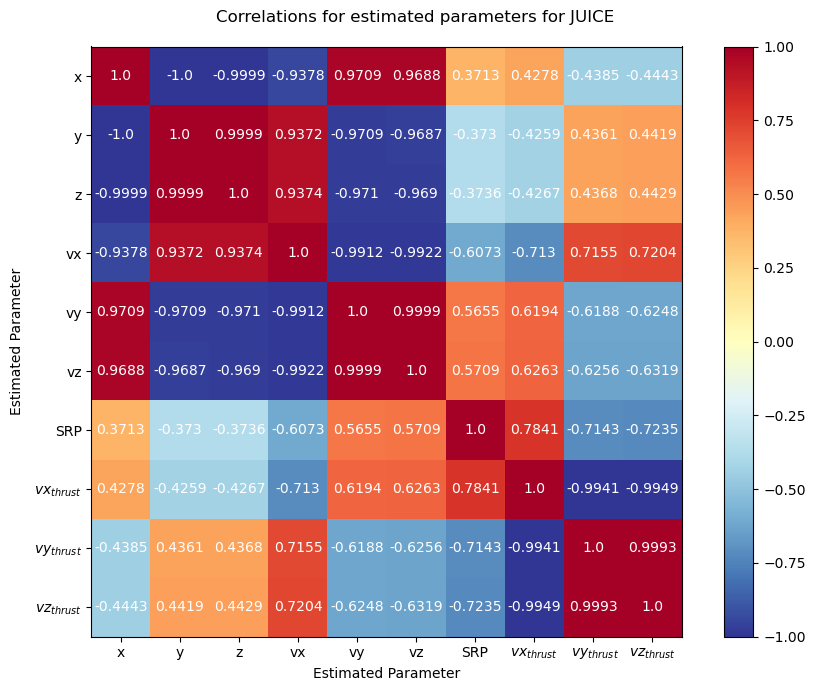

In [21]:
# Correlation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation.CovarianceAnalysisInput(observation_collection)
covariance_output = estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz", "SRP","$vx_{thrust}$"," $vy_{thrust}$" , "$vz_{thrust}$"]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 4), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {'JUICE'}")

fig.set_tight_layout(True)

## Inertial, TSW, RSW Coordinate Frames: Different Insights

/var/folders/vw/h3bwl54d4h9fxt45xnkxm86jgk0dgk/T/ipykernel_17613/3424560041.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = spice.get_body_cartesian_state_at_epoch(


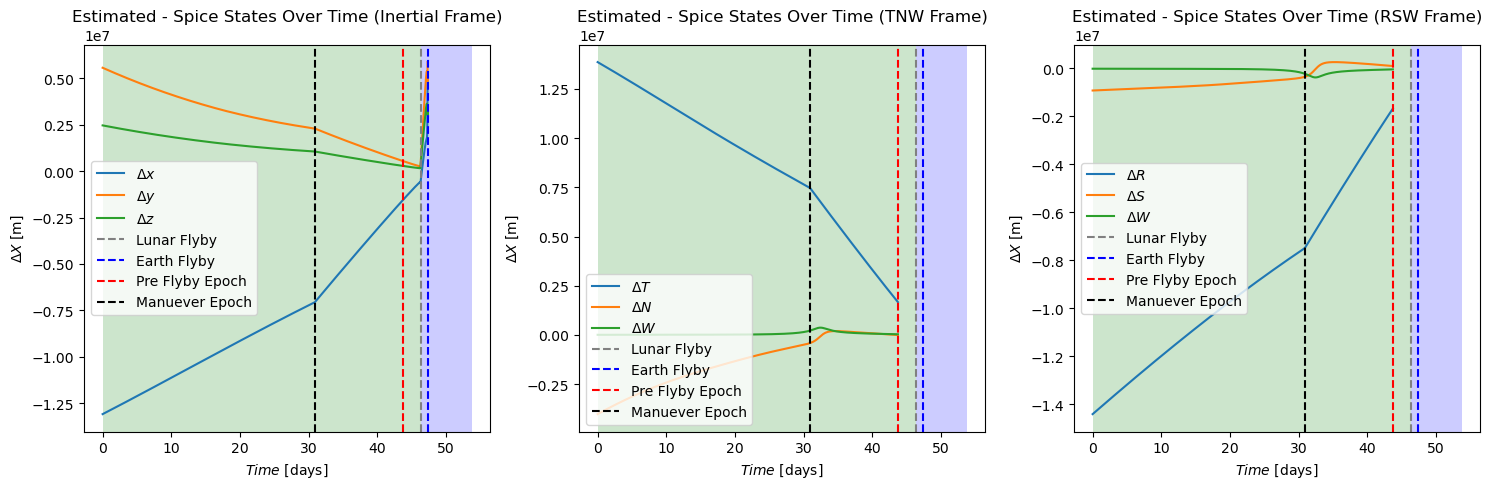

In [22]:
#Retrieve Estimated State History Form Estimation Output
simulator_object = estimation_output.simulation_results_per_iteration[-1]
state_history = simulator_object.dynamics_results.state_history
juice_prop = np.vstack(list(state_history.values()))

time2plt = np.vstack(list(state_history.keys()))

spice_states_new = []
for epoch in time2plt:
    state = spice.get_body_cartesian_state_at_epoch(
        '-28',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )

    spice_states_new.append(state)

x_spice_new = [state[0] for state in spice_states_new]
y_spice_new= [state[1] for state in spice_states_new]
z_spice_new= [state[2] for state in spice_states_new]
vx_spice_new = [state[3] for state in spice_states_new]
vy_spice_new= [state[4] for state in spice_states_new]
vz_spice_new= [state[5] for state in spice_states_new]

spice_states_array = np.array([x_spice_new,y_spice_new,z_spice_new,vx_spice_new,vy_spice_new,vz_spice_new]).T

# Normalize Times So That They Start At t=0
time2plt_normalized = (time2plt - time2plt[0]) / (3600*24)
time_manuever = (impulse_j2000 - time2plt[0]) / (3600*24)

# Pre-Flyby, Moon and Earth Flyby Epochs
pre_flyby_j2000= epoch_end_nobuffer

epoch_lunar = f'2024-08-19 21:15:00'
lunar_flyby = datetime.strptime(epoch_lunar, "%Y-%m-%d %H:%M:%S")
lunar_jd = Time(lunar_flyby).jd
lunar_j2000 = time_conversion.julian_day_to_seconds_since_epoch(lunar_jd)

epoch_earth = f'2024-08-20 21:56:00'
earth_flyby = datetime.strptime(epoch_earth, "%Y-%m-%d %H:%M:%S")
earth_jd = Time(earth_flyby).jd
earth_j2000 = time_conversion.julian_day_to_seconds_since_epoch(earth_jd)

# Calculate normalized times for flybys
pre_flyby_time = (pre_flyby_j2000 - time2plt[0]) / (3600*24)
lunar_flyby_time = (lunar_j2000 - time2plt[0]) / (3600*24)
earth_flyby_time = (earth_j2000 - time2plt[0]) / (3600*24)

pre_flyby_index = np.argmin(np.abs(time2plt_normalized - pre_flyby_time))
moon_index = np.argmin(np.abs(time2plt_normalized - lunar_flyby_time))
earth_index = np.argmin(np.abs(time2plt_normalized - earth_flyby_time))

# Create the main plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax1 =ax[0]
ax2 = ax[1]
ax3 = ax[2]

# Plot the main lines
ax1.plot(time2plt_normalized[:earth_index], (juice_prop[:earth_index, 0] - spice_states_array[:earth_index, 0]), label=r'$\Delta x$')
ax1.plot(time2plt_normalized[:earth_index], (juice_prop[:earth_index, 1] - spice_states_array[:earth_index, 1]), label=r'$\Delta y$')
ax1.plot(time2plt_normalized[:earth_index], (juice_prop[:earth_index, 2] - spice_states_array[:earth_index, 2]), label=r'$\Delta z$')
#ax1.plot(time2plt_normalized, np.linalg.norm((juice_prop[:, 0:3] - spice_states_array[:, 0:3]), axis=1), label=r'$||\Delta X||$')

# Add vertical lines for relevant epochs 
ax1.axvline(lunar_flyby_time, color='gray', linestyle='--', label='Lunar Flyby')
ax1.axvline(earth_flyby_time, color='blue', linestyle='--', label='Earth Flyby')
ax1.axvline(pre_flyby_time, color='red', linestyle='--', label='Pre Flyby Epoch')
ax1.axvspan(time2plt_normalized[moon_index][0],time2plt_normalized[-1][0] , facecolor='blue', alpha=0.2)
ax1.axvspan(time2plt_normalized[0][0],time2plt_normalized[moon_index][0] , facecolor='green', alpha=0.2)
ax1.axvline(time_manuever, color='black', linestyle='--', label='Manuever Epoch')
# Main plot settings
ax1.set_title("Estimated - Spice States Over Time (Inertial Frame)")
ax1.set_xlabel(r'$Time$ [days]')
ax1.set_ylabel(r'$\Delta X$ [m]')
ax1.legend(loc = 'center left')


# Rotation to the TNW Coordinates
Delta_X_tnw = juice_prop[:,0:5] - spice_states_array[:,0:5]

rot_Delta_X_tnw = np.empty([len(spice_states_array), 3])
for i, spice_state in enumerate(spice_states_array):
    rot_matrix_tnw = frame_conversion.inertial_to_tnw_rotation_matrix(spice_state)
    rot_Delta_X_tnw[i] = (rot_matrix_tnw @ Delta_X_tnw[i,0:3])

ax2.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X_tnw[:pre_flyby_index,0], label=r'$\Delta T$')
ax2.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X_tnw[:pre_flyby_index,1], label=r'$\Delta N$')
ax2.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X_tnw[:pre_flyby_index,2], label=r'$\Delta W$')

ax2.axvspan(time2plt_normalized[moon_index][0],time2plt_normalized[-1][0] , facecolor='blue', alpha=0.2)
ax2.axvspan(time2plt_normalized[0][0],time2plt_normalized[moon_index][0] , facecolor='green', alpha=0.2)

# Add a zoom box to the inset
ax2.axvline(lunar_flyby_time, color='gray', linestyle='--', label='Lunar Flyby')
ax2.axvline(earth_flyby_time, color='blue', linestyle='--', label='Earth Flyby')
ax2.axvline(pre_flyby_time, color='red', linestyle='--', label='Pre Flyby Epoch')
ax2.axvline(time_manuever, color='black', linestyle='--', label='Manuever Epoch')
ax2.set_title("Estimated - Spice States Over Time (TNW Frame)")
ax2.set_xlabel(r'$Time$ [days]')
ax2.set_ylabel(r'$\Delta X$ [m]')
ax2.legend(loc = 'lower left')

# Rotation to the RSW Coordinates
Delta_X = juice_prop[:,0:5] - spice_states_array[:,0:5]

rot_Delta_X = np.empty([len(spice_states_array), 3])
for i, spice_state in enumerate(spice_states_array):
    rot_matrix = frame_conversion.inertial_to_rsw_rotation_matrix(spice_state)
    rot_Delta_X[i] = (rot_matrix @ Delta_X[i,0:3])

ax3.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X[:pre_flyby_index,0], label=r'$\Delta R$')
ax3.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X[:pre_flyby_index,1], label=r'$\Delta S$')
ax3.plot(time2plt_normalized[:pre_flyby_index], rot_Delta_X[:pre_flyby_index,2], label=r'$\Delta W$')

ax3.axvspan(time2plt_normalized[moon_index][0],time2plt_normalized[-1][0] , facecolor='blue', alpha=0.2)
ax3.axvspan(time2plt_normalized[0][0],time2plt_normalized[moon_index][0] , facecolor='green', alpha=0.2)
ax3.axvline(lunar_flyby_time, color='gray', linestyle='--', label='Lunar Flyby')
ax3.axvline(earth_flyby_time, color='blue', linestyle='--', label='Earth Flyby')
ax3.axvline(pre_flyby_time, color='red', linestyle='--', label='Pre Flyby Epoch')
ax3.axvline(time_manuever, color='black', linestyle='--', label='Manuever Epoch')

ax3.set_title("Estimated - Spice States Over Time (RSW Frame)")
ax3.set_xlabel(r'$Time$ [days]')
ax3.set_ylabel(r'$\Delta X$ [m]')
ax3.legend(loc = 'center left')

plt.tight_layout()
plt.show()

## Zoom In!

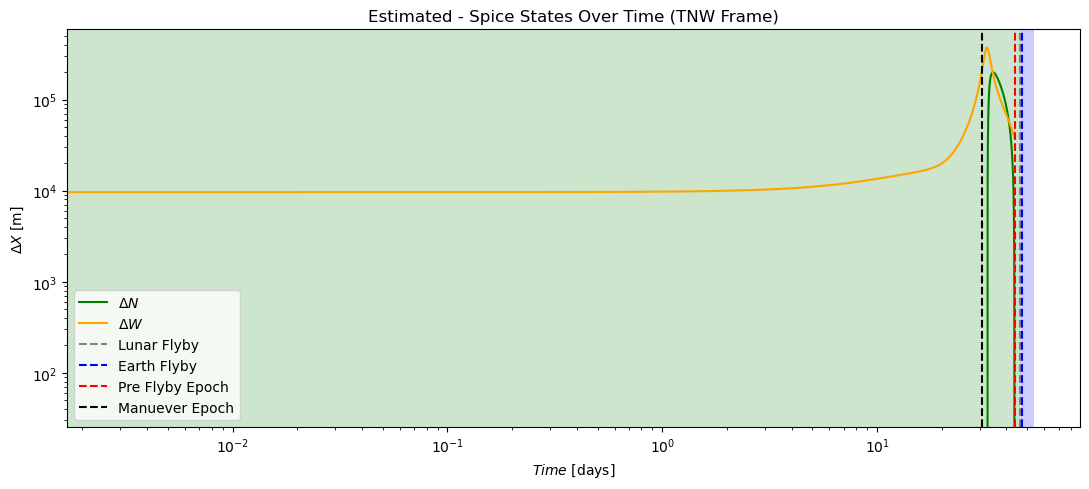

In [23]:
# Same as before, but showing 
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

ax2 = ax

ax2.loglog(time2plt_normalized[:pre_flyby_index], rot_Delta_X_tnw[:pre_flyby_index,1], color = 'green',label=r'$\Delta N$')
ax2.loglog(time2plt_normalized[:pre_flyby_index], rot_Delta_X_tnw[:pre_flyby_index,2], color = 'orange',label=r'$\Delta W$')

ax2.axvspan(time2plt_normalized[moon_index][0],time2plt_normalized[-1][0] , facecolor='blue', alpha=0.2)
ax2.axvspan(time2plt_normalized[0][0],time2plt_normalized[moon_index][0] , facecolor='green', alpha=0.2)
# Add a zoom box to the inset
ax2.axvline(lunar_flyby_time, color='gray', linestyle='--', label='Lunar Flyby')
ax2.axvline(earth_flyby_time, color='blue', linestyle='--', label='Earth Flyby')
ax2.axvline(pre_flyby_time, color='red', linestyle='--', label='Pre Flyby Epoch')
ax2.axvline(time_manuever, color='black', linestyle='--', label='Manuever Epoch')

ax2.set_title("Estimated - Spice States Over Time (TNW Frame)")
ax2.set_xlabel(r'$Time$ [days]')
ax2.set_ylabel(r'$\Delta X$ [m]')
ax2.legend(loc = 'lower left')

plt.tight_layout()
plt.show()

/var/folders/vw/h3bwl54d4h9fxt45xnkxm86jgk0dgk/T/ipykernel_17613/1974524351.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = spice.get_body_cartesian_state_at_epoch(


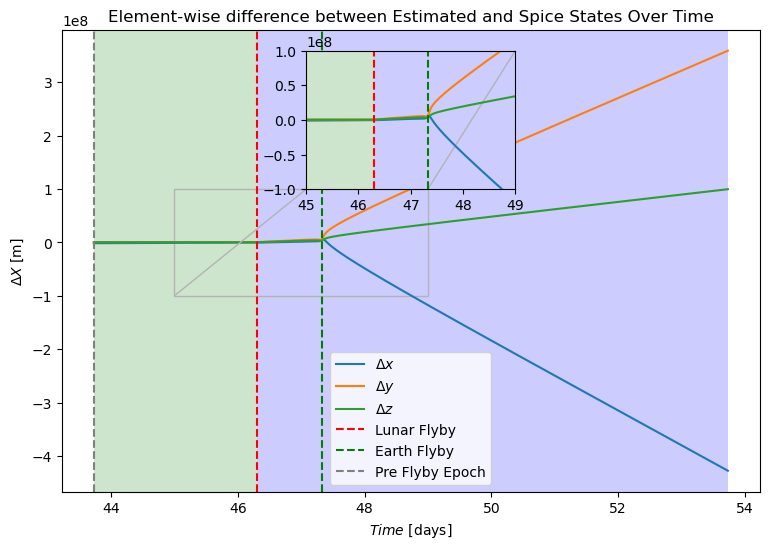

In [24]:
#Retrieve Estimated State History Form Estimation Output
simulator_object = estimation_output.simulation_results_per_iteration[-1]

state_history = simulator_object.dynamics_results.state_history
juice_prop = np.vstack(list(state_history.values()))

time2plt = np.vstack(list(state_history.keys()))

spice_states_new = []
for epoch in time2plt:
    state = spice.get_body_cartesian_state_at_epoch(
        '-28',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )

    spice_states_new.append(state)

x_spice_new = [state[0] for state in spice_states_new]
y_spice_new= [state[1] for state in spice_states_new]
z_spice_new= [state[2] for state in spice_states_new]
vx_spice_new = [state[3] for state in spice_states_new]
vy_spice_new= [state[4] for state in spice_states_new]
vz_spice_new= [state[5] for state in spice_states_new]

spice_states_array = np.array([x_spice_new,y_spice_new,z_spice_new,vx_spice_new,vy_spice_new,vz_spice_new]).T

# Normalize Times So That They Start At t=0
time2plt_utc_short = (time2plt - time2plt[0]) / (3600*24)


# Convert dates to Julian Date and time format
epoch_lunar = f'2024-08-19 21:15:00'
epoch_earth = f'2024-08-20 21:56:00'
lunar_flyby = datetime.strptime(epoch_lunar, "%Y-%m-%d %H:%M:%S")
lunar_jd = Time(lunar_flyby).jd
lunar_j2000 = time_conversion.julian_day_to_seconds_since_epoch(lunar_jd)

earth_flyby = datetime.strptime(epoch_earth, "%Y-%m-%d %H:%M:%S")
earth_jd = Time(earth_flyby).jd
earth_j2000 = time_conversion.julian_day_to_seconds_since_epoch(earth_jd)

# Calculate normalized times for flybys
lunar_flyby_time = (lunar_j2000 - time2plt[0]) / (3600*24)
earth_flyby_time = (earth_j2000 - time2plt[0]) / (3600*24)

moon_index = np.argmin(np.abs(time2plt_utc_short - lunar_flyby_time))
earth_index = np.argmin(np.abs(time2plt_utc_short - earth_flyby_time))
# Create the main plot
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

# Plot the main lines
ax1.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 0] - spice_states_array[pre_flyby_index:, 0]), label=r'$\Delta x$')
ax1.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 1] - spice_states_array[pre_flyby_index:, 1]), label=r'$\Delta y$')
ax1.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 2] - spice_states_array[pre_flyby_index:, 2]), label=r'$\Delta z$')
#ax1.plot(time2plt_utc_short, np.linalg.norm((juice_prop[:, 0:3] - spice_states_array[:, 0:3]), axis=1), label=r'$||\Delta X||$')

# Add vertical lines for flybys
ax1.axvline(lunar_flyby_time, color='red', linestyle='--', label='Lunar Flyby')
ax1.axvline(earth_flyby_time, color='green', linestyle='--', label='Earth Flyby')
ax1.axvline(pre_flyby_time, color='gray', linestyle='--', label='Pre Flyby Epoch')

ax1.axvspan(time2plt_utc_short[moon_index][0],time2plt_utc_short[-1][0] , facecolor='blue', alpha=0.2)
ax1.axvspan(time2plt_utc_short[pre_flyby_index][0],time2plt_utc_short[moon_index][0] , facecolor='green', alpha=0.2)

# Main plot settings
ax1.set_title("Element-wise difference between Estimated and Spice States Over Time")
ax1.set_xlabel(r'$Time$ [days]')
ax1.set_ylabel(r'$\Delta X$ [m]')
ax1.legend()

# Create the zoomed inset
axins = inset_axes(ax1, width="30%", height="30%", loc='upper center', borderpad=1.5)

# Set limits for zoom (around lunar flyby for this example)
zoom_start = lunar_flyby_time - 0.5  # Adjust this value for desired zoom range
zoom_end = lunar_flyby_time + 0.5

# Plot the zoomed portion in the inset
axins.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 0] - spice_states_array[pre_flyby_index:, 0]))
axins.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 1] - spice_states_array[pre_flyby_index:, 1]))
axins.plot(time2plt_utc_short[pre_flyby_index:], (juice_prop[pre_flyby_index:, 2] - spice_states_array[pre_flyby_index:, 2]))
#axins.plot(time2plt_utc_short, np.linalg.norm((juice_prop[:, 0:3] - spice_states_array[:, 0:3]), axis=1))

# Set limits for the inset zoom region
axins.set_xlim(45, 49)
axins.set_ylim(-1e8, 1e8)  # Adjust Y-axis limits based on your data for better zoom clarity

# Add a zoom box to the inset
axins.axvline(lunar_flyby_time, color='red', linestyle='--')
axins.axvline(earth_flyby_time, color='green', linestyle='--')
axins.axvline(pre_flyby_time, color='gray', linestyle='--')
axins.axvspan(time2plt_utc_short[moon_index][0],time2plt_utc_short[-1][0] , facecolor='blue', alpha=0.2)
axins.axvspan(time2plt_utc_short[0][0],time2plt_utc_short[moon_index][0] , facecolor='green', alpha=0.2)
# Add lines connecting the inset to the main plot using `mark_inset`
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.7")  # 'loc1' and 'loc2' control corners connected

# Tight layout for the plot
plt.show()

Using matplotlib backend: module://matplotlib_inline.backend_inline


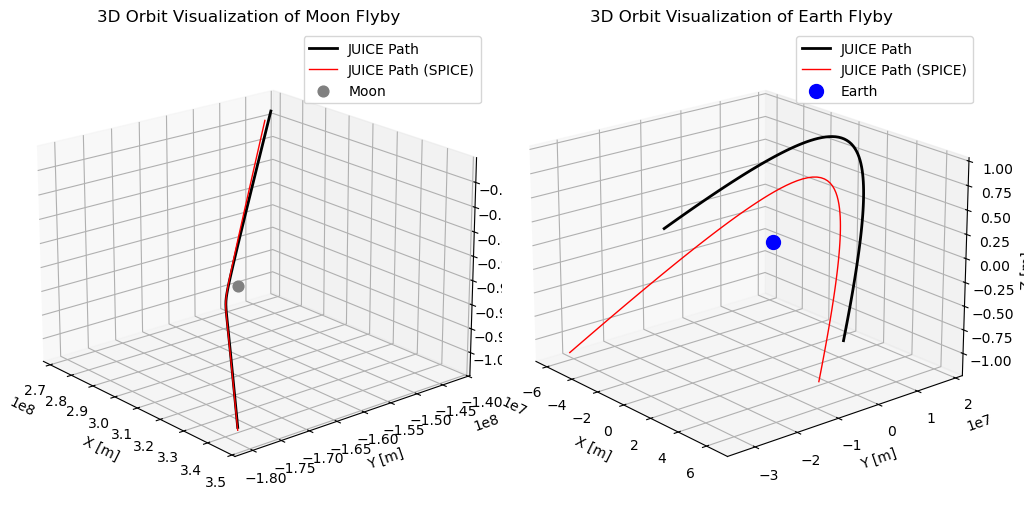

In [25]:

from mpl_toolkits.mplot3d import Axes3D
%matplotlib

# Your data processing code here (time2plt, juice_prop, spice_states_array, lunar_flyby_time, earth_flyby_time)

# Create a 3D figure and axis
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


# Plot the orbit in 3D
#ax.plot(juice_prop[15000:18000, 0], juice_prop[15000:18000, 1], juice_prop[15000:18000, 2], label='Orbit Path', color='b', lw=2)

moon_index = np.argmin(np.abs(time2plt_normalized - lunar_flyby_time))
earth_index = np.argmin(np.abs(time2plt_normalized - earth_flyby_time))

ax1.plot(juice_prop[(moon_index-50):(moon_index+50), 0], juice_prop[(moon_index-50):(moon_index+50), 1], juice_prop[(moon_index-50):(moon_index+50), 2], label='JUICE Path', color='black', lw=2)
ax2.plot(juice_prop[(earth_index-50):(earth_index+50), 0], juice_prop[(earth_index-50):(earth_index+50), 1], juice_prop[(earth_index-50):(earth_index+50), 2], label='JUICE Path', color='black', lw=2)

ax1.plot(spice_states_array[(moon_index-50):(moon_index+50), 0], spice_states_array[(moon_index-50):(moon_index+50), 1], spice_states_array[(moon_index-50):(moon_index+50), 2], label='JUICE Path (SPICE)', color='r', lw=1)
ax2.plot(spice_states_array[(earth_index-50):(earth_index+50), 0], spice_states_array[(earth_index-50):(earth_index+50), 1], spice_states_array[(earth_index-50):(earth_index+50), 2], label='JUICE Path (SPICE)', color='r', lw=1)


state_moon = spice.get_body_cartesian_state_at_epoch(
        'Moon',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        lunar_j2000,
    )


state_earth = [0,0,0,0,0,0]


# Mark the lunar and earth flyby points
ax1.scatter(state_moon[0],
           state_moon[1],
           state_moon[2], 
           color='grey', label='Moon', s=60)

ax2.scatter(state_earth[0],
           state_earth[0],
           state_earth[0], 
           color='blue', label='Earth', s=100)


# Labels and title
ax1.set_title("3D Orbit Visualization of Moon Flyby")
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')
ax1.set_zlabel('Z [m]')
ax1.legend()

ax2.set_title("3D Orbit Visualization of Earth Flyby")
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')
ax2.set_zlabel('Z [m]')
ax2.legend()

# Customize the 3D view
ax1.view_init(elev=20, azim=-40)  # Adjust viewing angle (elevation and azimuth)
ax2.view_init(elev=20, azim=-40)  # Adjust viewing angle (elevation and azimuth)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()